In [1]:
import pandas as pd
import geopandas as gpd
import datetime
import numpy as np

from datetime import timedelta
import os


In [2]:

def assign_time_bin(df, aggregation_period):
    start_date = df['occ_date'].min().floor('D')  # Dataset's start date
    end_date = df['occ_date'].max().ceil('D') + timedelta(aggregation_period) # Dataset's end date
    time_bins = pd.date_range(start=start_date, end=end_date, freq=f'{aggregation_period}D')

    # Bin the timestamps
    df['time_bin'] = pd.cut(
        df['occ_date'],
        bins=time_bins,
        labels=time_bins[:-1],  # Label bins by their start date
        right=False
    )
    df['time_bin'] = df['time_bin'].astype('datetime64[ns]')

    return df

def prepare_data(crime_df, grid_df, aggregation_period):
    relevant_columns = ['occ_date', 'x_coordinate', 'y_coordinate']
    crime_df = crime_df[relevant_columns]

    crime_df = gpd.GeoDataFrame(crime_df, geometry=gpd.points_from_xy(crime_df.x_coordinate, crime_df.y_coordinate))
    crime_df.set_crs('EPSG:2913', inplace=True)

    grid_crime_df = gpd.sjoin(crime_df, grid_df, how='left', predicate='within')
    grid_crime_df.dropna(inplace=True) # drop those crimes that don't fall within any grids inside the city boundry

    grid_crime_df.drop('index_right', axis=1, inplace=True)

    grid_crime_df['occ_date'] = pd.to_datetime(grid_crime_df['occ_date'])  # Ensure time is datetime
    grid_crime_df['hotspot'] = grid_crime_df['hotspot'].astype('int64')  
    grid_crime_df['unique_id'] = grid_crime_df['unique_id'].astype('int64') 

    # Aggregate crime counts over 14 days period
    # grid_crime_df['time_bin'] = grid_crime_df['occ_date'].dt.floor(f'{aggregation_period}D')
    grid_crime_df = assign_time_bin(grid_crime_df, aggregation_period)
    grid_crime_df['day_of_week'] = grid_crime_df['occ_date'].dt.dayofweek

    crime_counts_df = grid_crime_df.groupby(['unique_id', 'time_bin']).size().reset_index(name='crime_count')

    return crime_counts_df

def fill_in_hotspots(crime_counts_df,  hotspot_cells, threshold):
    
    # hotspot_cells = crime_counts_df.groupby(['unique_id']).agg({'crime_count': lambda x: any(x >= 5)})

    # hotspot_cells = hotspot_cells[hotspot_cells['crime_count'] == True].index

    potential_hotspots_crime_counts_df = crime_counts_df[crime_counts_df['unique_id'].isin(hotspot_cells)]
    potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0
    potential_hotspots_crime_counts_df.loc[ potential_hotspots_crime_counts_df['crime_count'] >= threshold , 'hotspot'] = 1

    return potential_hotspots_crime_counts_df

def create_sequences(df, seq_length):
    sequences = []
    for cell_id in df['unique_id'].unique():
        cell_data = df[df['unique_id'] == cell_id].sort_values('time_bin')
        for i in range(len(cell_data) - seq_length ):
            sequence = cell_data.iloc[i: i + seq_length + 1]
            sequences.append(sequence)
    return sequences



In [3]:

current_dir = os.getcwd()
train_base_dir = os.path.join(current_dir, "Data", "train")
test_base_dir = os.path.join(current_dir, "Data", "test")

cell_size = 600
aggregation_period = 14 # In days

train_crime_df = pd.read_csv(os.path.join(train_base_dir,'combined_train_data.csv'))
test_crime_df = pd.read_csv(os.path.join(test_base_dir,'test_data.csv'))

grid_df = gpd.read_file(os.path.join(current_dir, 'Data', 'grids', str(cell_size),  'crime-forecast-grid.shp'))

train_crime_counts_df = prepare_data(train_crime_df, grid_df, aggregation_period)
test_crime_counts_df = prepare_data(test_crime_df, grid_df, aggregation_period)

threshold = train_crime_counts_df.crime_count.quantile(0.98)
print(threshold)
hotspot_cells = train_crime_counts_df.groupby(['unique_id']).agg({'crime_count': lambda x: any(x >= threshold)})

hotspot_cells = hotspot_cells[hotspot_cells['crime_count'] == True].index


train_hotspots_crime_counts_df = fill_in_hotspots(train_crime_counts_df, hotspot_cells, threshold)
test_hotspots_crime_counts_df = fill_in_hotspots(test_crime_counts_df, hotspot_cells, threshold)

sequence_length = 26 # looking over whole year data to capture seasonal trend
last_time_bin = train_hotspots_crime_counts_df.time_bin.max()


5.0


/tmp/ipykernel_69858/229502313.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0
/tmp/ipykernel_69858/229502313.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_hotspots_crime_counts_df.loc[:,'hotspot'] = 0


In [4]:

start_time_bin_test_data_dependends_upon = last_time_bin - timedelta(aggregation_period*(sequence_length-1))
historical_data_for_test_df = train_hotspots_crime_counts_df[train_hotspots_crime_counts_df.time_bin >= start_time_bin_test_data_dependends_upon ]
test_hotspots_crime_counts_df = pd.concat([historical_data_for_test_df, test_hotspots_crime_counts_df])

#Ensuring all the same cells in both train and test data
# np.all(hotspot_cells == np.sort(test_hotspots_crime_counts_df.unique_id.unique()) )
test_hotspots_crime_counts_df.unique_id.unique().size
test_hotspots_crime_counts_df.unique_id.unique().size
# test_hotspots_crime_counts_df
hotspot_cells


Index([ 1290,  1292,  1370,  1371,  1448,  1522,  1637,  1752,  1753,  2096,
       ...
       11515, 11516, 11517, 11586, 11587, 11686, 11693, 11735, 11781, 11822],
      dtype='int64', name='unique_id', length=351)

In [5]:
train_time_bins = pd.date_range(train_crime_counts_df.time_bin.min(), train_crime_counts_df.time_bin.max(), freq='14d')
test_time_bin_history = pd.date_range(start_time_bin_test_data_dependends_upon, train_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins = pd.date_range(test_crime_counts_df.time_bin.min(), test_crime_counts_df.time_bin.max(), freq='14d')
test_time_bins = test_time_bin_history.append(test_time_bins)
# test_time_bins = np.concatenate([test_time_bin_history, test_time_bins])

grid_time_bin_train_df = pd.DataFrame([(grid, time_bin) for grid in hotspot_cells for time_bin in train_time_bins],columns=['unique_id', 'time_bin'])
grid_time_bin_test_df = pd.DataFrame([(grid, time_bin) for grid in hotspot_cells for time_bin in test_time_bins],columns=['unique_id', 'time_bin'])
# test_time_bins
# test_time_bin_history
# pd.array(np.concatenate([train_time_bins, test_time_bins]))

In [6]:
train_hotspots_crime_counts_df = grid_time_bin_train_df.merge(train_hotspots_crime_counts_df, on=['unique_id', 'time_bin'], how='left').fillna(0)
test_hotspots_crime_counts_df = grid_time_bin_test_df.merge(test_hotspots_crime_counts_df, on=['unique_id', 'time_bin'], how='left').fillna(0)

train_hotspots_crime_counts_df.time_bin.max(), test_hotspots_crime_counts_df.time_bin.max()


(Timestamp('2017-02-23 00:00:00'), Timestamp('2017-05-24 00:00:00'))

In [7]:
train_hotspots_crime_counts_df['hotspot'] = train_hotspots_crime_counts_df['hotspot'].astype(int)
test_hotspots_crime_counts_df['hotspot'] = test_hotspots_crime_counts_df['hotspot'].astype(int)

test_hotspots_crime_counts_df

,unique_id,time_bin,crime_count,hotspot
0,1290,2016-03-10,1.0,0
1,1290,2016-03-24,2.0,0
2,1290,2016-04-07,1.0,0
3,1290,2016-04-21,2.0,0
4,1290,2016-05-05,2.0,0
...,...,...,...,...
11578,11822,2017-03-29,1.0,0
11579,11822,2017-04-12,2.0,0
11580,11822,2017-04-26,3.0,0
11581,11822,2017-05-10,0.0,0


In [8]:
train_data_pivot = train_hotspots_crime_counts_df.pivot(index='time_bin', columns='unique_id', values='crime_count')
test_data_pivot = test_hotspots_crime_counts_df.pivot(index='time_bin', columns='unique_id', values='crime_count')
train_array = train_data_pivot.to_numpy()  # Convert to NumPy for model input
test_array = test_data_pivot.to_numpy()  # Convert to NumPy for model input

# train_data_pivot

In [9]:
import numpy as np


# Final Data Shape for Modeling
# Save data for Further Use
np.save(f'train_data_{cell_size}.npy', train_array)
np.save(f'test_data_{cell_size}.npy', test_array)

# Model Building

In [10]:
from sklearn.model_selection import train_test_split


#  Prepare trainable Data sequences
def create_sequences(data, sequence_length) :
    # Reshape data into (samples, sequence_length, features) for modeling.
    sequences = [data[i:i + sequence_length + 1] for i in range(len(data) - sequence_length)]
    labels = data[sequence_length:]  # Target: crime levels at sequence_length+1
    return sequences, labels
    # return np.array(sequences), np.array(labels)

# train_data = np.load(f'train_data_{cell_size}.npy')
# test_data = np.load(f'test_data_{cell_size}.npy')

train_data = train_data_pivot
test_data = test_data_pivot
sequence_length = 26


X_train_df, Y_train_df = create_sequences(train_data, sequence_length)
X_test_df, Y_test_df = create_sequences(test_data, sequence_length)

X_train, Y_train, X_test, Y_test = np.array(X_train_df), np.array(Y_train_df), np.array(X_test_df), np.array(Y_test_df)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=1)

# X_test, y_test = create_sequences()
Y_train = np.expand_dims(Y_train,axis=1)
Y_test = np.expand_dims(Y_test,axis=1)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((94, 27, 351), (94, 1, 351), (7, 27, 351), (7, 1, 351))

## Regression

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

import tensorflow.keras.backend as K


2024-12-02 17:31:05.932158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# import keras.backend as K
# Step 2: Build the LSTM model


num_features = X_train.shape[2]


model = Sequential([
    LSTM(80, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(20, return_sequences=False),
    Dense(num_features, activation='relu') ,
])

# from tensorflow.keras.losses import BinaryCrossentropy


optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy', 'precision', 'recall'])


/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:

# Step 3: Train the Model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=60, batch_size=32, validation_data=(X_val,Y_val), callbacks=[early_stopping])



Epoch 1/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 384ms/step - accuracy: 0.0000e+00 - loss: 5.1875 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 6.0450 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.0000e+00 - loss: 5.2901 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 6.0267 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0000e+00 - loss: 5.1816 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 6.0107 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0000e+00 - loss: 5.1679 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 5.9925 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.0000e+00 - l

In [15]:

# x = tf.constant(X_test)
# y = tf.constant(Y_test)
Y_test = Y_test.reshape(Y_test.shape[0],Y_test.shape[2])
# Step 4: Evaluate the Model
evaluation= model.evaluate(X_test, Y_test)
print(evaluation)
# print(f"Test Accuracy: {accuracy:.2f}")
# X_test.shape
# Y_test.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.0000e+00 - loss: 5.1620 - precision: 0.6339 - recall: 0.3165
[5.1619977951049805, 0.0, 0.633941113948822, 0.3165266215801239]


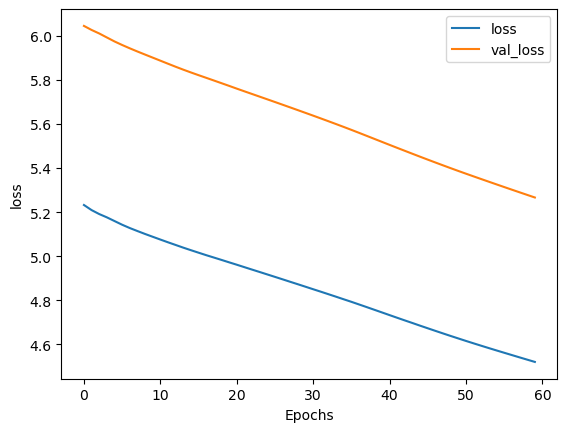

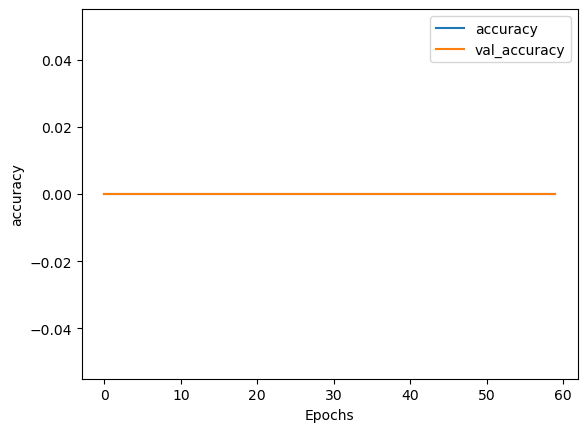

In [16]:
import matplotlib.pyplot as plt
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'loss')
plot_history(history, 'accuracy')
# plot_history(history, 'precision')
# plot_history(history, 'recall')

# history.history
# result = model.predict(X, verbose=0)
# result

In [26]:

x_test = np.expand_dims(X_test[6], axis=0)
y_test = np.expand_dims(Y_test[6], axis=1)

threshold = 5
# Step 5: Make Predictions
predictions = model.predict(x_test)
# predicted_labels = np.argmax(predictions, axis=1)
pthreshold = np.quantile(predictions,0.98)
# print(predictions.max())
print(pthreshold)
# print(predictions>=pthreshold)
# threshold = threshold
# pthreshold = threshold
hotspots_predicted = (predictions >= pthreshold)[0].astype(int)
hotspots_actual  = (y_test >= threshold).astype(int)

hotspots_predicted =hotspots_predicted.reshape(-1)
hotspots_actual = hotspots_actual.reshape(-1)

# hotspots_predicted.sum()
y_test = y_test.reshape(-1)

pi = np.where(hotspots_predicted == 1)[0]
# print(hotspots_predicted)
print(pi)
ai = np.where(y_test >= threshold)
print(ai)

# len(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0.8240745067596436
[ 83  97 104 115 151 251 277 309]
(array([ 41,  49,  50,  96,  98, 103, 104, 105, 106, 111, 138, 212]),)


In [27]:
predicted_grid_ids = hotspot_cells[pi]
actual_grid_ids = hotspot_cells[ai]
intersection = np.intersect1d(predicted_grid_ids, actual_grid_ids)
# actual_grid_ids
intersection

array([5156])

In [20]:
TP = np.intersect1d(predicted_grid_ids, actual_grid_ids).size
FP = np.setdiff1d(predicted_grid_ids, actual_grid_ids).size
FN = np.setdiff1d(actual_grid_ids, predicted_grid_ids).size
TN =  np.setdiff1d(hotspot_cells, np.union1d(actual_grid_ids, predicted_grid_ids)).size

print(TP)
print(FP)
print(FN)
print(TN)
# Accuracy calculation
accuracy = (TP + TN) / (TP + FP + FN + TN)

# Precision calculation
precision = TP / (TP + FP) if (TP + FP) != 0 else 0

# Recall calculation
recall = TP / (TP + FN) if (TP + FN) != 0 else 0

# F1-Score calculation
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")


1
7
11
332
Accuracy: 0.95
Precision: 0.12
Recall: 0.08
F1-Score: 0.10


In [21]:
# ppd_grids_clipped = gpd.read_file(f"../Qgis/self-created-grid/{grid_size}/crime-forecast-grid.shp")
grid = gpd.read_file(os.path.join(current_dir, 'Data', 'grids', str(cell_size), 'crime-forecast-grid.shp'))


In [22]:
total_crimes =  test_crime_counts_df[test_crime_counts_df['time_bin'].dt.date == datetime.date(2017,3,1)].crime_count.sum()
total_crimes

1381

In [23]:
# For categorical:
# predicted_hotspots_area = predicted_grid_ids.size  # Number of predicted hotspot grid cells
# predicted_grid_ids
total_crimes_in_predicted_hotspots = y_test[pi].sum()
total_crimes =  test_crime_counts_df[test_crime_counts_df['time_bin'].dt.date == datetime.date(2017,3,1)].crime_count.sum()
# total_crimes = test_crime_counts_df .sum()
predicted_hotspots_area = grid[grid.unique_id.isin(predicted_grid_ids)].area.sum()
total_area = grid.area.sum()
print(y_test)
print(y_test[pi])
print(total_crimes_in_predicted_hotspots)
print(total_crimes)
print(predicted_hotspots_area)
print(total_area)

# predicted_hotspots_area

pai = (total_crimes_in_predicted_hotspots / total_crimes) / (predicted_hotspots_area / total_area)
# # 
total_area, predicted_hotspots_area / (cell_size ** 2), pai
# # pai



[3. 1. 2. 1. 0. 2. 0. 0. 0. 0. 2. 1. 0. 0. 0. 0. 0. 2. 0. 2. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 2. 1. 2. 0. 1. 0. 3. 1. 0. 0. 8. 0. 2. 1. 0. 0. 0.
 0. 5. 5. 2. 0. 1. 4. 1. 0. 0. 0. 3. 3. 1. 2. 1. 1. 0. 1. 1. 0. 3. 0. 0.
 1. 1. 4. 0. 0. 1. 0. 3. 1. 0. 1. 2. 0. 0. 2. 2. 2. 2. 1. 1. 1. 3. 4. 3.
 5. 4. 8. 1. 2. 0. 1. 8. 9. 5. 5. 0. 0. 0. 1. 7. 3. 1. 0. 2. 0. 1. 1. 2.
 2. 2. 0. 0. 0. 3. 4. 0. 0. 0. 2. 2. 2. 1. 0. 1. 0. 3. 8. 0. 4. 2. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 2. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 1. 2. 1. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 3. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 2. 0. 0. 0. 0. 0. 0. 3. 0. 2. 1. 1. 1. 1. 0. 0. 0. 0. 5. 2. 0. 2.
 0. 1. 0. 1. 0. 1. 2. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 1. 1.
 0. 0. 2. 0. 0. 0. 1. 2. 0. 0. 1. 0. 2. 0. 0. 1. 0. 2. 1. 3. 1. 2. 1. 0.
 0. 0. 1. 1. 2. 1. 1. 0. 0. 1. 0. 0. 0. 2. 0. 0. 1. 2. 1. 0. 2. 0. 1. 1.
 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 1. 0. 0. 2. 0. 1. 0. 1. 0. 0. 0.

(4117743414.8055296, 8.0, 19.671012571733712)

In [24]:

grid[grid.unique_id.isin(actual_grid_ids)]
desc_sorted_y_test = -np.sort(-y_test)
# print(desc_sorted_y_test)
number_of_cells = int(predicted_hotspots_area/ (cell_size**2))
maximum_obtainable_crimes_for_the_forecasted_area = desc_sorted_y_test[:number_of_cells].sum()
# print(maximum_obtainable_crimes_for_the_forecasted_area)
pei = total_crimes_in_predicted_hotspots / (maximum_obtainable_crimes_for_the_forecasted_area)
pei
# y_test

0.3275862068965517

In [5]:


# Spatial join: Assign crimes to grid cells
crime_with_grids = gpd.sjoin(geo_crime_data, grids, how='left', predicate='within')

crime_with_grids.unique_id.unique().size
crime_with_grids.dropna(inplace=True) # drop those rows that don't fall within any grids inside the city boundry

crime_with_grids.drop('index_right', axis=1, inplace=True)

crime_with_grids['occ_date'] = pd.to_datetime(crime_with_grids['occ_date'])  # Ensure time is datetime
crime_with_grids['hotspot'] = crime_with_grids['hotspot'].astype('int64')  
crime_with_grids['unique_id'] = crime_with_grids['unique_id'].astype('int64') 

# Aggregate crime counts over 14 days period
crime_with_grids['time_bin'] = crime_with_grids['occ_date'].dt.floor('14d')
# crime_with_grids['day_of_week'] = crime_with_grids['occ_date'].dt.dayofweek

# Find no of crimes over the grids in the specified time period
# training_crime_with_grids = 
crime_counts = crime_with_grids.groupby(['unique_id', 'time_bin']).size().reset_index(name='crime_count')
crime_counts

,unique_id,time_bin,crime_count
0,26,2012-07-05,1
1,32,2013-07-04,1
2,32,2013-09-12,1
3,49,2015-11-05,1
4,57,2013-02-28,1
...,...,...,...
118513,11929,2015-12-31,1
118514,11949,2014-09-25,1
118515,11950,2013-06-06,1
118516,11950,2015-08-13,1


In [9]:

# crime_counts.time_bin.min()
len(crime_counts.time_bin.dt.date.unique())
threshold = crime_counts.crime_count.quantile(0.98)

potential_hostspots_ids = crime_counts[crime_counts['crime_count'] >= threshold].unique_id.unique()

threshold
# crime_counts.crime_count.value_counts()

5.0

In [11]:
import datetime
# crime_counts.time_bin.min()
# pd.date_range(start=crime_counts.time_bin.min(), end=crime_counts.time_bin.max(), freq='14D')
len(potential_hostspots_ids)

351

In [12]:
# Step 5: Create Spatio-Temporal Tensor
# Initialize tensor with all possible grid-time combinations
# grid_ids =  crime_counts['unique_id'].unique() 
grid_ids = potential_hostspots_ids 
time_bins = pd.date_range(start=crime_counts['time_bin'].min(), 
                          end=crime_counts['time_bin'].max(), freq='14D')
tensor = pd.DataFrame([(grid, time) for grid in grid_ids for time in time_bins],columns=['unique_id', 'time_bin'])
time_bins


DatetimeIndex(['2012-03-01', '2012-03-15', '2012-03-29', '2012-04-12',
               '2012-04-26', '2012-05-10', '2012-05-24', '2012-06-07',
               '2012-06-21', '2012-07-05',
               ...
               '2016-10-20', '2016-11-03', '2016-11-17', '2016-12-01',
               '2016-12-15', '2016-12-29', '2017-01-12', '2017-01-26',
               '2017-02-09', '2017-02-23'],
              dtype='datetime64[ns]', length=131, freq='14D')

In [13]:

tensor_crime_counts = tensor.merge(crime_counts, on=['unique_id', 'time_bin'], how='left').fillna(0)
train_data = tensor_crime_counts[tensor_crime_counts.time_bin.dt.date < datetime.date(2017,3,1)]
test_data = tensor_crime_counts[tensor_crime_counts.time_bin.dt.date >= datetime.date(2017,3,1)]
# train_data = crime_counts[crime_counts.time_bin.dt.date < datetime.date(2017,3,1)]
# test_data = crime_counts[crime_counts.time_bin.dt.date >= datetime.date(2017,3,1)]

In [14]:
# tensor_crime_counts.crime_count.value_counts()
# tensor_crime_counts.crime_count.quantile(0.9999)
# tensor_crime_counts.crime_count.quantile(0.95)
# tensor_crime_counts
train_data.unique_id.unique().size

351

In [15]:
# Step 6: Reshape for Modeling
# Pivot to create time-series data for each grid cell
# tensor_pivot = tensor_crime_counts.pivot(index='time_bin', columns='unique_id', values='crime_count')
train_data_pivot = train_data.pivot(index='time_bin', columns='unique_id', values='crime_count')
test_data_pivot = test_data.pivot(index='time_bin', columns='unique_id', values='crime_count')
train_array = train_data_pivot.to_numpy()  # Convert to NumPy for model input
test_array = test_data_pivot.to_numpy()  # Convert to NumPy for model input


In [16]:
# tensor_array_normalized = (tensor_array - tensor_array.min()) / (tensor_array.max() - tensor_array.min())
# len(tensor_array_normalized)
train_data_pivot.fillna(0,inplace=True)
test_data_pivot.fillna(0,inplace=True)

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow.keras.backend as K






2024-12-02 08:31:53.793226: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Step 1: Data Preparation
def prepare_data(data, time_steps):
    """
    Reshape data into (samples, time_steps, features) for modeling.
    """
    # cells = grid_size[0] * grid_size[1]
    # data = data.reshape(-1, number_of_cells)
    sequences = [data[i:i + time_steps] for i in range(len(data) - time_steps)]
    labels = data[time_steps:]  # Target: crime levels at time_steps+1
    return np.array(sequences), np.array(labels)

train_data = np.load(f'train_data_{cell_size}.npy')
test_data = np.load(f'test_data_{cell_size}.npy')
time_steps = 26
# X_test = data[len(data)-time_steps:]

# sequences = np.array([data[i:i + time_steps] for i in range(len(data) - time_steps)])
# labels = np.array(data[time_steps:])
# sequences.shape
# labels.shape
# data.shape
# X_test.reshape(1, 24, -1)
# X_test.shape

X_train, Y_train = prepare_data(train_data, time_steps)
# x_test = np.array([data[i:i + time_steps] for i in range(len(data) - time_steps)])
x_test = train_data[len(train_data)-time_steps:] # data for predicting first week
x_test = x_test.reshape(1,time_steps,-1)
y_test = test_data[0]
x_test.shape
y_test = y_test.reshape(1,1,-1)
y_test.shape, x_test.shape
# test_data.shape

# X_test, y_test = prepare_data()



((1, 1, 23883), (1, 24, 23883))

In [ ]:

# Example: Load and preprocess dataset
# data = np.load('crime_tensor.npy')  

time_steps = 24
X_train, Y_train = prepare_data(train_data, time_steps)
X_test, Y_test = prepare_data(test_data, time_steps)

# Normalize data
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# y = to_categorical((y > threshold).astype(int), num_classes=2)
# print("Updated  shape:", y.shape)  # (85, 11985, 2)
# y = (y > threshold).astype(int)  # Label as hotspot (1) or non-hotspot (0)
# y = np.expand_dims(y, axis=1)  # Shape will now be (85, 1, 11985)
# y_test = np.expand_dims(y_test, axis=1)
# Split data
# X_train, X_test, Y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Y_train = np.expand_dims(Y_train, axis=1)
# Y_train = (Y_train >= threshold).astype(int)
Y_test = np.expand_dims(Y_test, axis=1)

X_train.shape ,Y_train.shape, X_test.shape, Y_test.shape


((107, 24, 23883), (107, 1, 23883), (0,), (0, 1, 23883))

In [ ]:
X_train.shape,Y_train.shape
# Y_train  = Y_train.reshape(85,1,11985)
# Y_train.shape

# from tensorflow.keras.utils import to_categorical

# Y_train = to_categorical((Y_train > threshold).astype(int), num_classes=2)
# print("Updated Y_train shape:", Y_train.shape)  # (85, 11985, 2)

((107, 24, 23883), (107, 1, 23883))

In [171]:
# from keras.layers import LSTM, Dense, Lambda
# import keras.backend as K
# Step 2: Build the LSTM model

features = 11985
features = 6973
features = 1939
features = X_train.shape[2]


model = Sequential([
    LSTM(120, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(60, return_sequences=False),
    Dense(features, activation='relu') ,
])

from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import BinaryCrossentropy


# optimizer = Adam(learning_rate=0.0001)

# model.compile(optimizer=optimizer, loss='mse')
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'precision', 'recall', 'f1-score'])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'precision', 'recall'])


/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-11-30 17:05:38.239256: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 45855360 exceeds 10% of free system memory.
2024-11-30 17:05:38.285785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 45855360 exceeds 10% of free system memory.
2024-11-30 17:05:38.316454: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 45855360 exceeds 10% of free system memory.


In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define the model
Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[2]))

features = X_train.shape[2]
model = Sequential([
    LSTM(120, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(60, return_sequences=False),
    Dense(features, activation='sigmoid')  # Binary classification for all features
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']  # Add other metrics after training, if needed
)

# Train the model
history = model.fit(
    X_train, Y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1
)

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


2024-11-30 16:27:54.113798: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 47232000 exceeds 10% of free system memory.


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 504ms/step - accuracy: 0.0000e+00 - loss: 0.6909 - val_accuracy: 0.0000e+00 - val_loss: 0.6758
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.0000e+00 - loss: 0.6692 - val_accuracy: 0.0000e+00 - val_loss: 0.6425
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.0000e+00 - loss: 0.6332 - val_accuracy: 0.0000e+00 - val_loss: 0.5993
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.0000e+00 - loss: 0.5890 - val_accuracy: 0.0000e+00 - val_loss: 0.5519
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.0000e+00 - loss: 0.5412 - val_accuracy: 0.0000e+00 - val_loss: 0.5054
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.0000e+00 - loss: 0.4954 - val_accuracy: 0.0000e+00 - val_loss: 0.4637
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.0000e+00 - loss: 0.4545 - val_accuracy: 0.0000e+00 - val_loss: 0.4291
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.01

KeyboardInterrupt: 

In [172]:

# Step 3: Train the Model
history = model.fit(X_train, Y_train, epochs=60, batch_size=32, validation_split=0.1)

# Step 4: Evaluate the Model
# some= model.evaluate(X_test, y_test)
# print(f"Test Accuracy: {accuracy:.2f}")


Epoch 1/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.0000e+00 - loss: 0.0873 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0791 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.0000e+00 - loss: 0.0851 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0765 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.0000e+00 - loss: 0.0809 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0745 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.0000e+00 - loss: 0.0779 - precision: 0.4515 - recall: 0.0027 - val_accuracy: 0.0000e+00 - val_loss: 0.0732 - val_precision: 0.5346 - val_recall: 0.0541
Epoch 5/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.0000e+00 - loss: 0.0753 - precision: 0

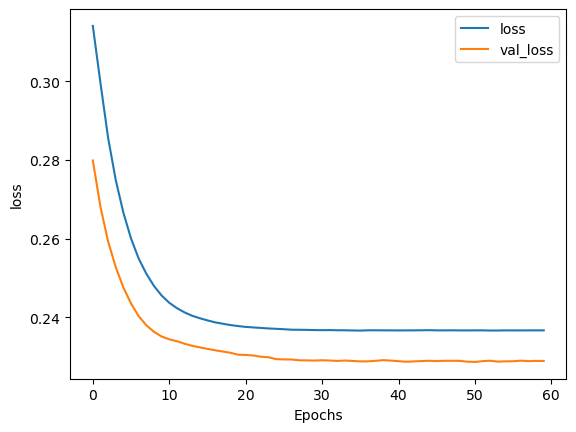

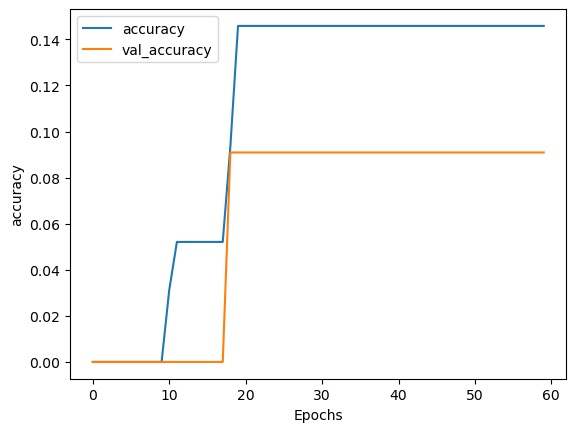

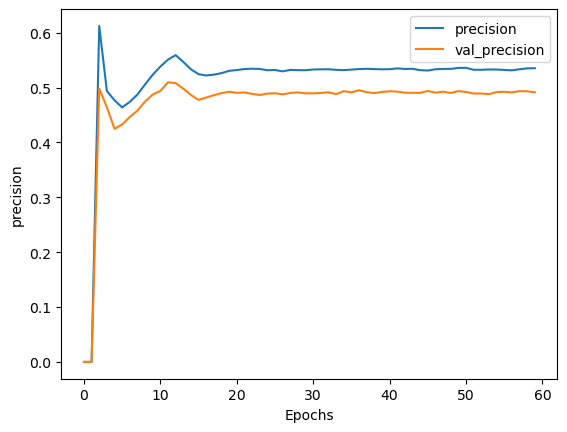

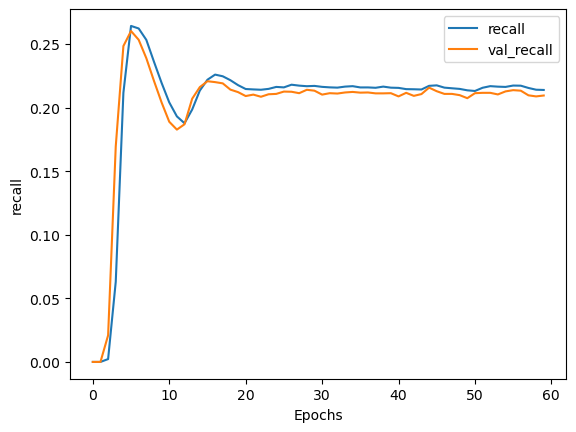

In [128]:
import matplotlib.pyplot as plt
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'loss')
plot_history(history, 'accuracy')
plot_history(history, 'precision')
plot_history(history, 'recall')

# history.history
# result = model.predict(X, verbose=0)
# result

In [129]:
# model.evaluate(x_test, y_test.reshape((1,y_test.shape[2])))
model.evaluate(x_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0000e+00 - loss: 0.2546 - precision: 0.5290 - recall: 0.2147


[0.25456950068473816, 0.0, 0.5289855003356934, 0.21470588445663452]

In [139]:

# Step 5: Make Predictions
predictions = model.predict(x_test)
# predicted_labels = np.argmax(predictions, axis=1)
# threshold = np.quantile(predictions,0.95)
# print(threshold)
# threshold = threshold
pthreshold = threshold

hotspots_predicted = (predictions >= pthreshold).astype(int)
hotspots_actual  = (y_test >= threshold).astype(int)

hotspots_predicted =hotspots_predicted.reshape(-1)
hotspots_actual = hotspots_actual.reshape(-1)

# hotspots_predicted.sum()
y_test = y_test.reshape(-1)

pi = np.where(hotspots_predicted == 1)[0]
print(pi)
ai = np.where(y_test >= threshold)
print(ai)

# len(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[1156 1157 1160 1161 1231 1272 1304 1307 1329 1863 2019 3202 3775]
(array([   9,   28,   31,   91,  387,  464,  543,  565,  567,  578,  640,
        668,  678,  709,  734,  735,  814,  821,  875,  879,  882,  889,
        890,  973,  989,  994, 1004, 1042, 1082, 1115, 1150, 1151, 1155,
       1157, 1160, 1161, 1162, 1163, 1193, 1198, 1228, 1229, 1234, 1239,
       1266, 1270, 1272, 1273, 1276, 1277, 1304, 1306, 1307, 1309, 1329,
       1388, 1401, 1408, 1427, 1432, 1450, 1454, 1481, 1510, 1522, 1523,
       1539, 1577, 1579, 1584, 1589, 1594, 1606, 1646, 1647, 1744, 1779,
       1806, 1835, 1850, 1856, 1862, 1865, 1883, 1902, 1924, 1934, 1939,
       1945, 1959, 1991, 2017, 2127, 2200, 2272, 2282, 2291, 2382, 2394,
       2423, 2496, 2707, 2741, 2751, 2795, 2886, 2927, 3107, 3131, 3202,
       3215, 3254, 3274, 3280, 3287, 3343, 3352, 3354, 3386, 3549, 3572,
       3746, 3748, 3758, 3764, 3775, 3818, 3841, 3851, 3863, 3888, 3892,
       3903, 3917,

In [140]:
intersect = np.intersect1d(pi, ai)
print(len(intersect))
intersect
len(pi)

9


13

In [141]:
predicted_grid_ids = grid_ids[pi]
actual_grid_ids = grid_ids[ai]
intersection = np.intersect1d(predicted_grid_ids, actual_grid_ids)
# actual_grid_ids

In [149]:
TP = np.intersect1d(predicted_grid_ids, actual_grid_ids).size
FP = np.setdiff1d(predicted_grid_ids, actual_grid_ids).size
FN = np.setdiff1d(actual_grid_ids, predicted_grid_ids).size
TN =  np.setdiff1d(grid_ids, np.union1d(actual_grid_ids, predicted_grid_ids)).size

print(TP)
print(FP)
print(FN)
print(TN)
# Accuracy calculation
accuracy = (TP + TN) / (TP + FP + FN + TN)

# Precision calculation
precision = TP / (TP + FP) if (TP + FP) != 0 else 0

# Recall calculation
recall = TP / (TP + FN) if (TP + FN) != 0 else 0

# F1-Score calculation
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")


9
4
160
4952
Accuracy: 0.97
Precision: 0.69
Recall: 0.05
F1-Score: 0.10


In [ ]:
ppd_grids_clipped = gpd.read_file(f"../Qgis/self-created-grid/{grid_size}/crime-forecast-grid.shp")


In [155]:
# For categorical:
predicted_hotspots_area = predicted_grid_ids.size  # Number of predicted hotspot grid cells
# predicted_grid_ids
total_crimes_in_predicted_hotspots = y_test[pi].sum()
total_crimes = y_test.sum()
predicted_hotspots_area = ppd_grids_clipped[ppd_grids_clipped.unique_id.isin(predicted_grid_ids)].area.sum()
total_area = ppd_grids_clipped.area.sum()

print(total_crimes_in_predicted_hotspots)
print(total_crimes)
print(predicted_hotspots_area)
print(total_area)


pai = (total_crimes_in_predicted_hotspots / total_crimes) / (predicted_hotspots_area / total_area)
# maximum_obtainable_crimes_for_the_forecasted_area = 
# 
total_area, predicted_hotspots_area / (grid_size ** 2), pai
# pai



37.0
928.0
812500.0
4117743414.806666


(4117743414.806666, 13.0, 202.0643320263218)

In [145]:
4117743414.806666 / (5280**2)

147.70372097418308

In [153]:
predicted_hotspots_area = predicted_grid_ids.size  # Number of predicted hotspot grid cells
predicted_grid_ids
total_crimes_in_predicted_hotspots = y_test[pi].sum()
total_crimes = y_test.sum()
predicted_hotspots_area = ppd_grids_clipped[ppd_grids_clipped.unique_id.isin(predicted_grid_ids)].area.sum()
total_area = ppd_grids_clipped.area.sum()
# total_crimes_in_predicted_hotspots = np.sum(y_test[hotspots_predicted == 1])
# total_area = hotspots_predicted.size  # Total grid cells
# total_crimes = np.sum(y_test)
pai = (total_crimes_in_predicted_hotspots / total_crimes) / (predicted_hotspots_area / total_area)
# maximum_obtainable_crimes_for_the_forecasted_area = 
# 
total_area, predicted_hotspots_area / (grid_size**2), pai
# pai

(4117743414.806666, 13.0, 202.0643320263218)

In [152]:

ppd_grids_clipped[ppd_grids_clipped.unique_id.isin(actual_grid_ids)]
desc_sorted_y_test = -np.sort(-y_test)
print(desc_sorted_y_test)
number_of_cells = int(predicted_hotspots_area/ (grid_size**2))
maximum_obtainable_crimes_for_the_forecasted_area = desc_sorted_y_test[:number_of_cells].sum()
# print(maximum_obtainable_crimes_for_the_forecasted_area)
pei = total_crimes_in_predicted_hotspots / (maximum_obtainable_crimes_for_the_forecasted_area)
pei
# y_test

[9. 7. 6. ... 0. 0. 0.]


0.5211267605633803

In [82]:
ppd_grids_clipped.loc[ppd_grids_clipped.unique_id.isin(predicted_grid_ids), 'hotspot'] = 1
ppd_grids_clipped.loc[ppd_grids_clipped.unique_id.isin(actual_grid_ids), 'hotspot'] = 2
ppd_grids_clipped.loc[ppd_grids_clipped.unique_id.isin(np.intersect1d(predicted_grid_ids, actual_grid_ids)), 'hotspot'] = 3
ppd_grids_clipped.to_file(f"../Qgis/outputs/{grid_size}/crime-forecast-grid.shp")
ppd_grids_clipped


,unique_id,hotspot,area,geometry
0,0,0,14186.758187,"POLYGON ((7604006.821 710565.558, 7604254.588 ..."
1,1,0,60642.865787,"POLYGON ((7604017.212 710815.558, 7604254.588 ..."
2,2,0,58045.115882,"POLYGON ((7604027.603 711065.558, 7604254.588 ..."
3,3,0,55447.365977,"POLYGON ((7604037.994 711315.558, 7604254.588 ..."
4,4,0,52849.616072,"POLYGON ((7604048.385 711565.558, 7604254.588 ..."
...,...,...,...,...
67367,67367,0,8664.770476,"POLYGON ((7701004.588 699546.139, 7701004.588 ..."
67368,67368,0,39576.748305,"POLYGON ((7701254.588 699628.656, 7701254.588 ..."
67369,67369,0,8.423069,"POLYGON ((7701009.290 699815.558, 7701004.588 ..."
67370,67370,0,7362.488508,"POLYGON ((7701254.588 699515.658, 7701254.588 ..."


In [60]:
# For trimming purposes
import numpy as np
grids_with_crime = gpd.sjoin(geo_crime_data, grids, how='left', predicate='within')

# grids_with_crime[grids_with_crime['area'] < 360000].groupby(['unique_id', 'time_bin']).size().reset_index(name='crime_count')
grid_ids_with_crime = grids_with_crime.unique_id.unique()
grid_ids_without_crime = np.setdiff1d(grids.unique_id.unique(), grid_ids_with_crime)
# total_crimes_in_smaller_grids[total_crimes_in_smaller_grids['unique_id'] == 1488]
# total_crimes_in_smaller_grids
grids_with_crime
# crime_grid_ids.size
grid_ids_without_crime.size
grids_without_crime = grids[grids.unique_id.isin(grid_ids_without_crime)]
trimmable_grids = grids_without_crime[(grids_without_crime['area'] < 360000/4) & (grids_without_crime['area'] > 360000/100)].sort_values('area')
trimmable_grid_ids = trimmable_grids.unique_id.reset_index().drop('index', axis=1)
trimmable_grid_ids = tuple(trimmable_grid_ids['unique_id'])
# trimmable_grid_ids
# total_crimes_in_smaller_grids = grids_with_crime[grids_with_crime['area'] < 360000].groupby(['unique_id', 'area']).size().reset_index(name='crime_count').sort_values(['crime_count','area'])

In [64]:
5280 ** 2

27878400

In [67]:
# Adjust the grid to meet target area
# Target area in square feet
sq_miles_to_sq_feet = 5280 ** 2  # Conversion factor
target_area_sq_ft = 147.71 * sq_miles_to_sq_feet
tolerance_sq_ft = 0.02 * sq_miles_to_sq_feet

i = 0
while True:
    total_area = ppd_grids_clipped["area"].sum()
    if abs(total_area - target_area_sq_ft) <= tolerance_sq_ft:
        break
    # Remove cells contributing least to area (trim marginally on the outer boundary)
    smallest_cell = trimmable_grids[i]
    i +=1 
    ppd_grids_clipped = ppd_grids_clipped[ppd_grids_clipped.index != smallest_cell.name]


In [77]:
ppd_grids_clipped
ppd_grids_clipped.area.sum() / sq_miles_to_sq_feet

147.70372097414233

In [71]:

tolerance_sq_ft = 0.02 * sq_miles_to_sq_feet
ppd_grids_clipped.area.sum() -  target_area_sq_ft , tolerance_sq_ft


(-175049.19447040558, 557568.0)

In [16]:
grids_with_crime = ppd_grids[ppd_grids['unique_id'].isin(crime_grid_ids)]
grids_with_crime.to_file('../Qgis/self-created-grid/crimes_with_grids/crime_with_grids_600.shp')

In [17]:
grids_with_crime

,unique_id,hotspot,area,geometry
26,26,0,360000.000000,"POLYGON ((7605804.588 711315.558, 7605204.588 ..."
32,32,0,360000.000000,"POLYGON ((7605804.588 714915.558, 7605204.588 ..."
49,49,0,360000.000000,"POLYGON ((7607004.588 713115.558, 7606404.588 ..."
57,57,0,360000.000000,"POLYGON ((7607604.588 711915.558, 7607004.588 ..."
58,58,0,360000.000000,"POLYGON ((7607604.588 712515.558, 7607004.588 ..."
...,...,...,...,...
11925,11925,0,360000.000000,"POLYGON ((7696404.588 693315.558, 7695804.588 ..."
11926,11926,0,360000.000000,"POLYGON ((7696404.588 693915.558, 7695804.588 ..."
11929,11929,0,301284.916228,"POLYGON ((7696404.588 695990.328, 7696404.588 ..."
11949,11949,0,115864.846542,"POLYGON ((7696812.494 695715.558, 7696404.588 ..."


In [52]:

from numpy import array
length = 5
seq = array([i/float(length) for i in range(length)])
print(seq)


[0.  0.2 0.4 0.6 0.8]


In [ ]:
X = seq.reshape(5, 1, 1)
y = seq.reshape(5, 1)


array([[0. ],
       [0.2],
       [0.4],
       [0.6],
       [0.8]])

/home/test/anaconda3/envs/saurav_sir_ann/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 5)              │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146 (584.00 B)

 Trainable params: 146 (584.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
1/1 - 1s - 1s/step - loss: 0.2909
Epoch 2/1000
1/1 - 0s - 23ms/step - loss: 0.2890
Epoch 3/1000
1/1 - 0s - 28ms/step - loss: 0.2872
Epoch 4/1000
1/1 - 0s - 26ms/step - loss: 0.2853
Epoch 5/1000
1/1 - 0s - 25ms/step - loss: 0.2834
Epoch 6/1000
1/1 - 0s - 26ms/step - loss: 0.2816
Epoch 7/1000
1/1 - 0s - 27ms/step - loss: 0.2798
Epoch 8/1000
1/1 - 0s - 25ms/step - loss: 0.2780
Epoch 9/1000
1/1 - 0s - 24ms/step - loss: 0.2762
Epoch 10/1000
1/1 - 0s - 25ms/step - loss: 0.2744
Epoch 11/1000
1/1 - 0s - 26ms/step - loss: 0.2726
Epoch 12/1000
1/1 - 0s - 28ms/step - loss: 0.2708
Epoch 13/1000
1/1 - 0s - 28ms/step - loss: 0.2690
Epoch 14/1000
1/1 - 0s - 32ms/step - loss: 0.2673
Epoch 15/1000
1/1 - 0s - 27ms/step - loss: 0.2656
Epoch 16/1000
1/1 - 0s - 28ms/step - loss: 0.2638
Epoch 17/1000
1/1 - 0s - 29ms/step - loss: 0.2621
Epoch 18/1000
1/1 - 0s - 29ms/step - loss: 0.2604
Epoch 19/1000
1/1 - 0s - 61ms/step - loss: 0.2587
Epoch 20/1000
1/1 - 0s - 29ms/step - loss: 0.2570
Epoch 

/tmp/ipykernel_9554/3374568893.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('%.1f' % value)


In [113]:
# # For trimming purposes
# import numpy as np
# grids_with_crime = gpd.sjoin(geo_crime_data, grids, how='left', predicate='within')

# # grids_with_crime[grids_with_crime['area'] < 360000].groupby(['unique_id', 'time_bin']).size().reset_index(name='crime_count')
# grid_ids_with_crime = grids_with_crime.unique_id.unique()
# grid_ids_without_crime = np.setdiff1d(grids.unique_id.unique(), grid_ids_with_crime)
# # total_crimes_in_smaller_grids[total_crimes_in_smaller_grids['unique_id'] == 1488]
# # total_crimes_in_smaller_grids
# grids_with_crime
# # crime_grid_ids.size
# grid_ids_without_crime.size
# grids_without_crime = grids[grids.unique_id.isin(grid_ids_without_crime)]
# trimmable_grids = grids_without_crime[(grids_without_crime['area'] < 360000/4) & (grids_without_crime['area'] > 360000/100)].sort_values('area')
# trimmable_grid_ids = trimmable_grids.unique_id.reset_index().drop('index', axis=1)
# list(trimmable_grid_ids['unique_id'])
# # total_crimes_in_smaller_grids = grids_with_crime[grids_with_crime['area'] < 360000].groupby(['unique_id', 'area']).size().reset_index(name='crime_count').sort_values(['crime_count','area'])

In [4]:


# def get_neighbor_ids(grid_cell):
#     neighbors = grids[grids.geometry.touches(grid_cell.geometry)]
#     return list(neighbors['unique_id'])

# grids['neighbor_ids'] = grids.apply(get_neighbor_ids, axis=1)
